In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data import load_daily, load_hourly, daily_from_hourly

plt.rcParams["figure.figsize"] = (20, 5)
π = np.pi

In [2]:
daily = load_daily()
hourly = load_hourly()

Step by Step Calculation of the Penman-Monteith Evapotranspiration
---------------------------------------
Method from https://edis.ifas.ufl.edu/pdffiles/ae/ae45900.pdf

In [3]:
# Saturation vapour pressure for temperature(s)
def svp(t):
    return 0.6108 * np.exp((17.27*t)/(t+237.3))

# Resample hourly to daily at 9am
def daily_from_hourly(hourly, variables):
    origin = hourly.index.min().replace(hour=9)
    resampler = hourly[variables].resample('D', origin=origin, label='right')
    return resampler.agg({v: "max" if v.endswith('max') else 'min' for v in variables})

<AxesSubplot:xlabel='timestamp'>

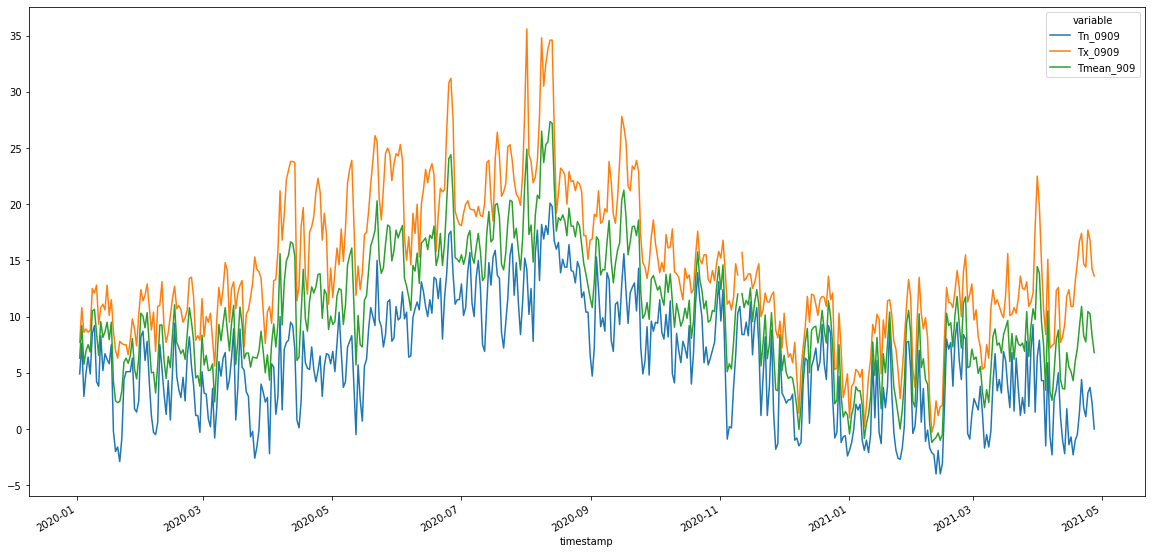

In [4]:
# Step 1 - Mean daily temperature
Tmax = daily['Tx_0909']
Tmin = daily['Tn_0909']
Tmean = daily['Tmean_909'] = (Tmax + Tmin)/2
daily[['Tn_0909', 'Tx_0909', 'Tmean_909']].loc['2020-01-01':].plot(figsize=(20, 10))

<AxesSubplot:xlabel='timestamp'>

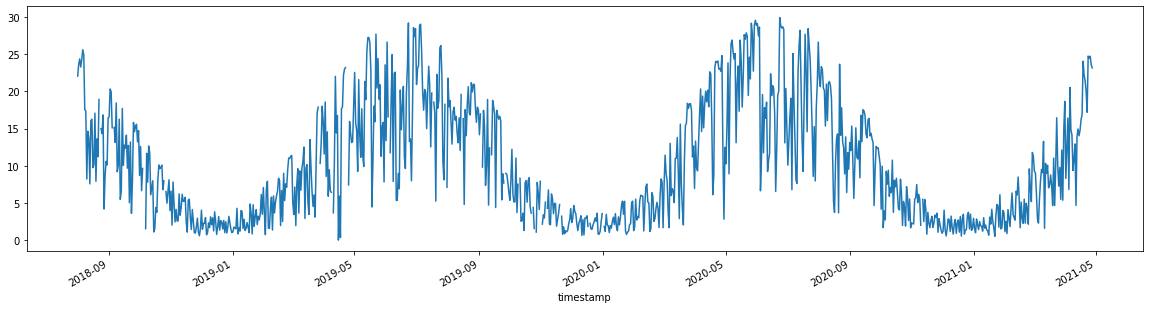

In [5]:
# Step 2 – Mean daily solar radiation
Rs = daily['srad_0024']  # Global solar radiation accumulation for yesterday (MJ/m2)
Rs.plot()

<AxesSubplot:xlabel='timestamp'>

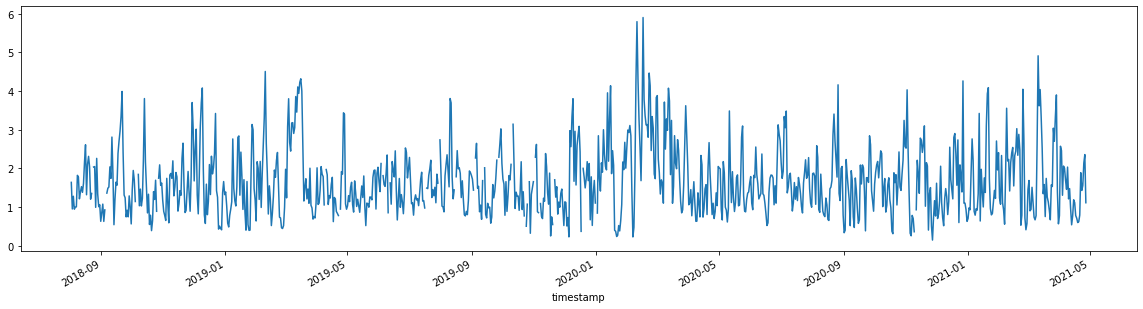

In [6]:
# Step 3 – Wind speed
u2 = daily['U2run_0909']*1_000/(24*60*60)  # Original unit is km / day
u2.plot()

<AxesSubplot:xlabel='timestamp'>

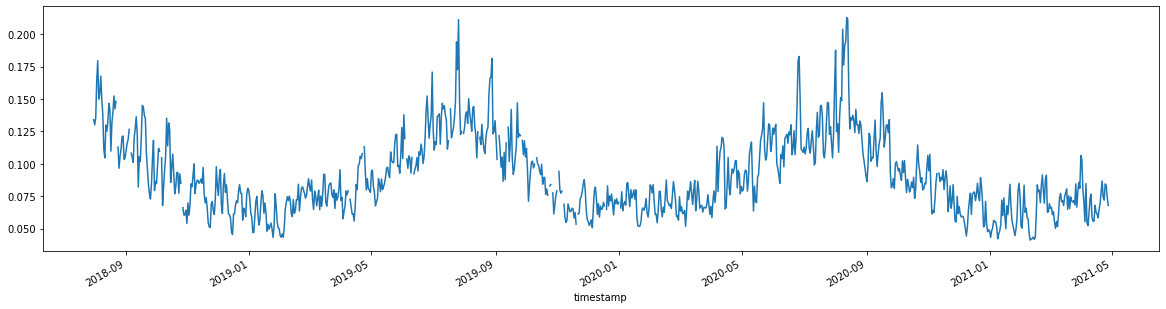

In [7]:
# Step 4 - Slope of saturation vapor pressure curve
Δ = 4098*svp(Tmean)/((Tmean+237.3)**2)
Δ.plot()

100.52226707656533

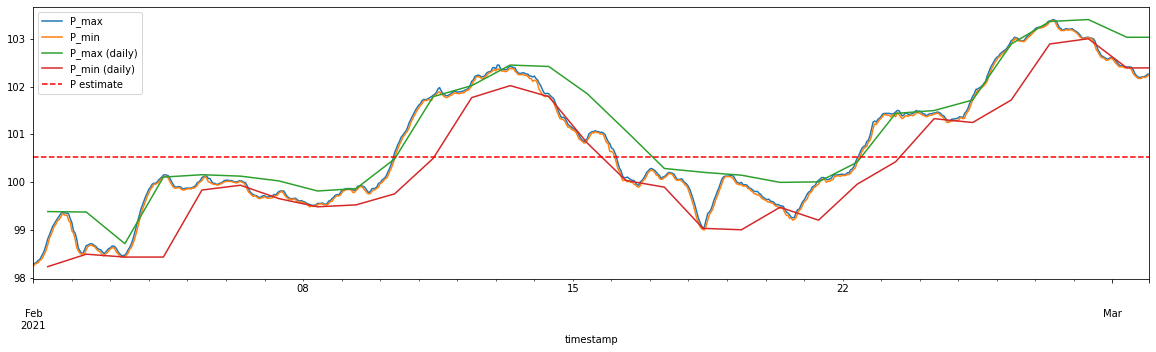

In [8]:
# Pressures
pressures_hourly = hourly[['P_max', 'P_min']]*0.1
pressures_daily = (daily_from_hourly(hourly, ['P_max', 'P_min'])*0.1).add_suffix(' (daily)')
ax = pressures_hourly.join(pressures_daily).loc['2021-02-01':'2021-03-01'].interpolate(method='linear').plot()
# This is the method recommended to estimate for an altitude, but why not use the real data? ;-)
z = 66
P = 101.3*(((293-0.0065*z)/293)**5.26)
ax.axhline(y=P, color='red', linestyle='--', label='P estimate')
ax.legend()
P

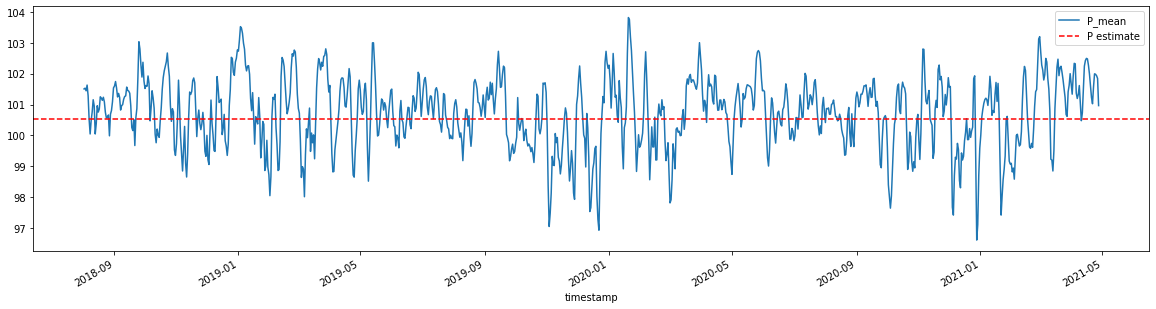

In [9]:
# Step 5 – Atmospheric Pressure
daily[['P_max', 'P_min']] = daily_from_hourly(hourly, ['P_max', 'P_min'])*0.1  # hPa to kPa
Pmean = (daily['P_max']+daily['P_min'])/2
ax = Pmean.plot(label='P_mean')
ax.axhline(y=P, color='red', linestyle='--', label='P estimate')
ax.legend()

<AxesSubplot:xlabel='timestamp'>

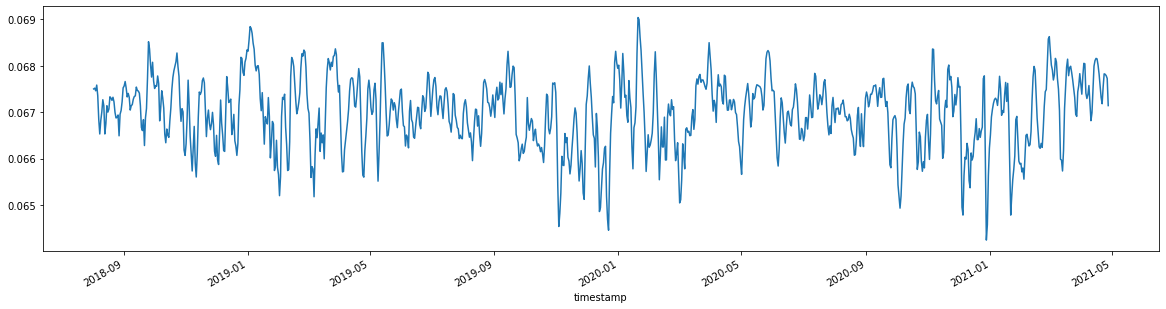

In [10]:
# Step 6 – Psychrometric constant
γ = 0.000665 * Pmean
γ.plot()

<AxesSubplot:xlabel='timestamp'>

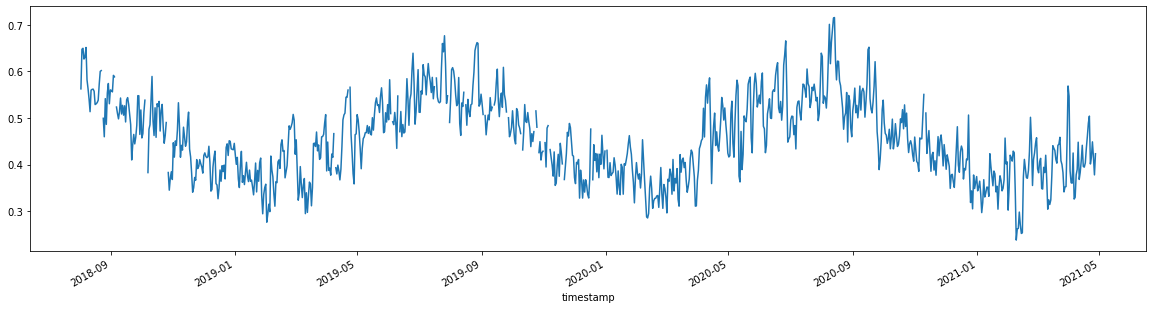

In [11]:
# Step 7 – Delta Term (DT) (auxiliary calculation for Radiation Term)
DT = Δ / (Δ + γ*(1+0.34*u2))
DT.plot()

<AxesSubplot:xlabel='timestamp'>

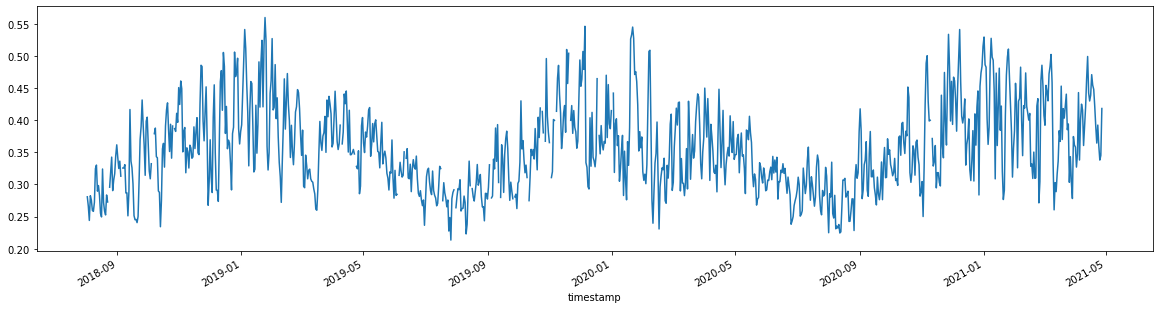

In [12]:
# Step 8 – Psi Term (PT) (auxiliary calculation for Wind Term)
PT = γ / (Δ + γ*(1 + 0.34*u2))
PT.plot()

<AxesSubplot:xlabel='timestamp'>

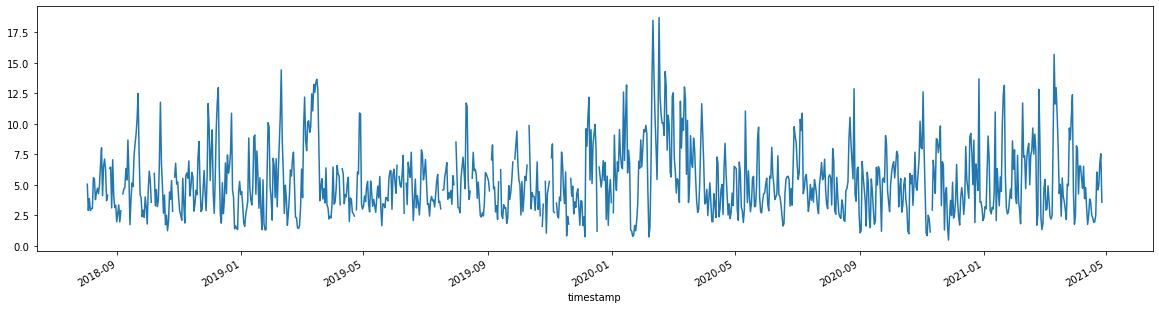

In [13]:
# Step 9 - Temperature Term (TT) (auxiliary calculation for Wind Term)
TT = (900/(Tmean+273))*u2
TT.plot()

<AxesSubplot:xlabel='timestamp'>

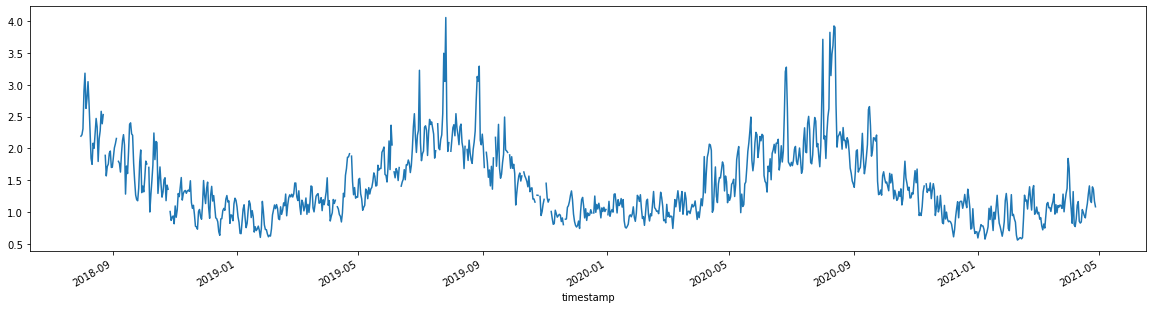

In [14]:
# Step 10 - Mean saturation vapor pressure derived from air temperature
es = (svp(Tmax)+svp(Tmin))/2
es.plot()

<AxesSubplot:xlabel='timestamp'>

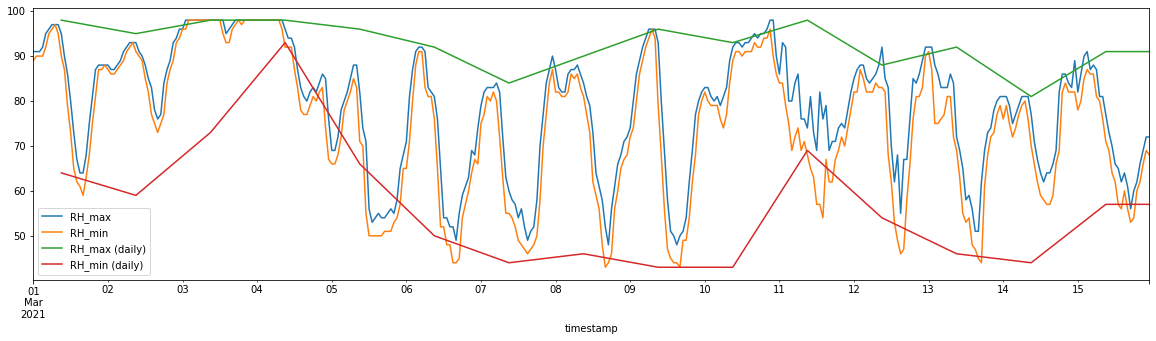

In [15]:
# Relative Humidity
pressures_hourly = hourly[['RH_max', 'RH_min']]
pressures_daily = (daily_from_hourly(hourly, ['RH_max', 'RH_min'])).add_suffix(' (daily)')
pressures_hourly.join(pressures_daily).loc['2021-03-01':'2021-03-15'].interpolate(method='linear').plot()

<AxesSubplot:xlabel='timestamp'>

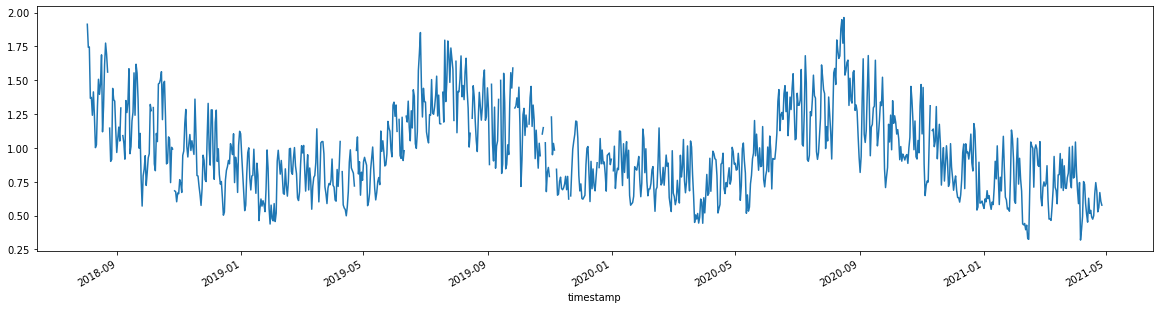

In [16]:
# Step 11 - Actual vapor pressure (ea) derived from relative humidity
daily[['RH_max', 'RH_min']] = daily_from_hourly(hourly, ['RH_max', 'RH_min'])
ea = (svp(Tmin)*daily['RH_max']/100 + svp(Tmax)*daily['RH_min']/100)/2
ea.plot()

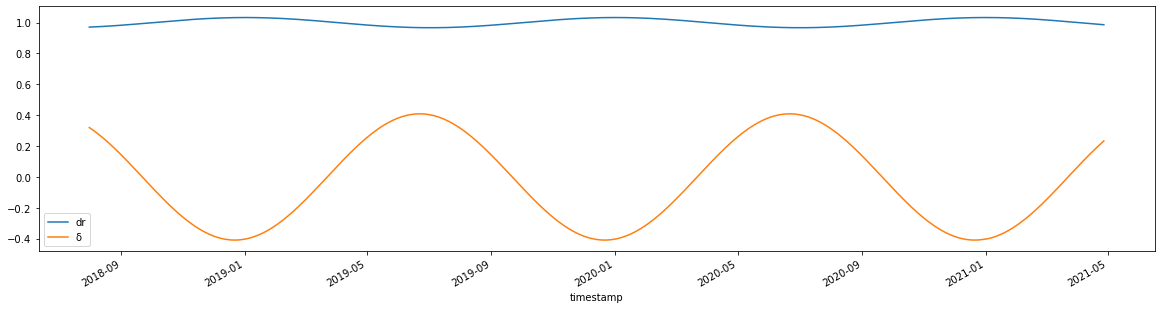

In [17]:
# Step 12 - The inverse relative distance Earth-Sun and solar declination 

# The shift is because the 9am timestamp is for the previous day
J = pd.Series(daily.index.shift(-1, freq='D').day_of_year, index=daily.index)

dr = 1 + 0.033*np.cos((2*π/365)*J)
dr.plot(label='dr')

δ = 0.409*np.sin((2*π/365)*J - 1.39)
ax = δ.plot(label='δ')
ax.legend()

In [18]:
# Step 13 - – Conversion of latitude in degrees to radians
latitude = 51.44136
φ = latitude*π/180
φ

0.8978211037037104

<AxesSubplot:xlabel='timestamp'>

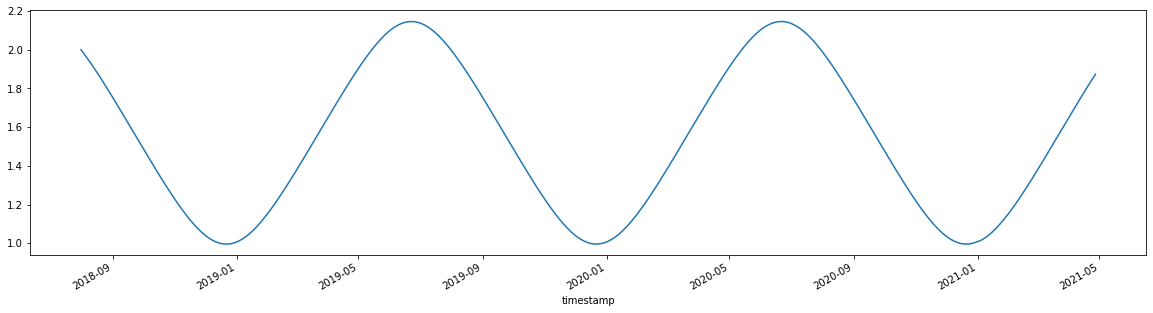

In [19]:
# Step 14 - Sunset hour angle
ωs = np.arccos(-np.tan(φ)*np.tan(δ))
ωs.plot()

<AxesSubplot:xlabel='timestamp'>

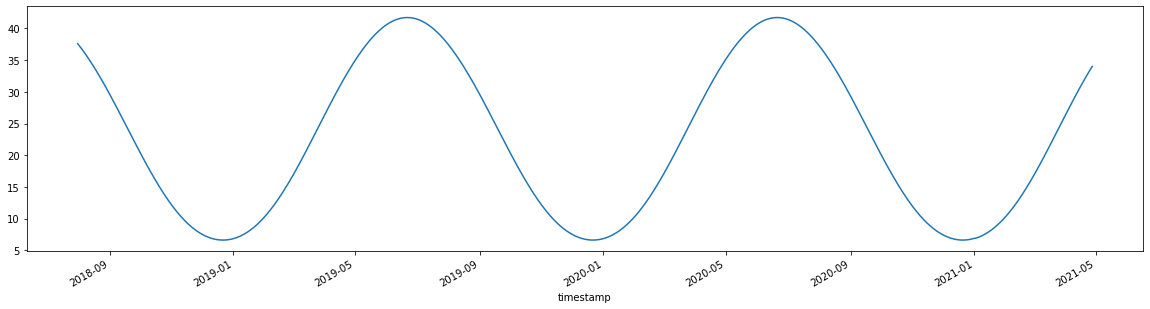

In [20]:
# Step 15 – Extraterrestrial radiation
Gsc = 0.0820

Ra = (24*60/π)*Gsc*dr*((ωs*np.sin(φ)*np.sin(δ)) + (np.cos(φ)*np.cos(δ)*np.sin(ωs)))
Ra.plot()

<AxesSubplot:xlabel='timestamp'>

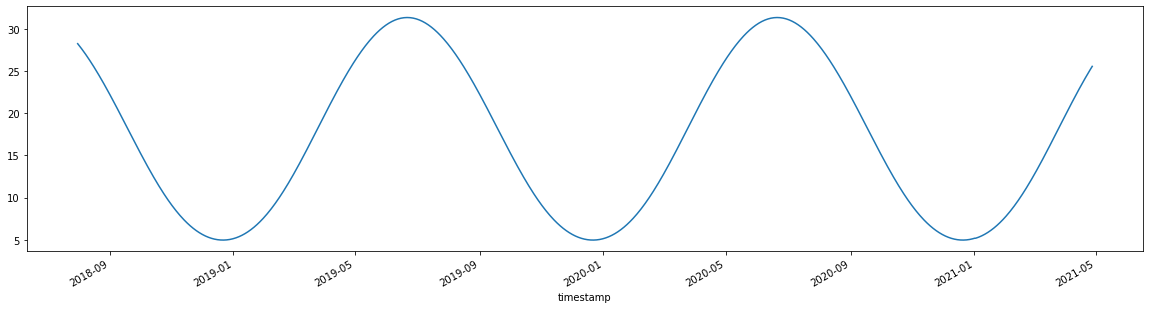

In [21]:
# Step 16 – Clear sky solar radiation
Rso = (0.75 + z*2e-5)*Ra
Rso.plot()

<AxesSubplot:xlabel='timestamp'>

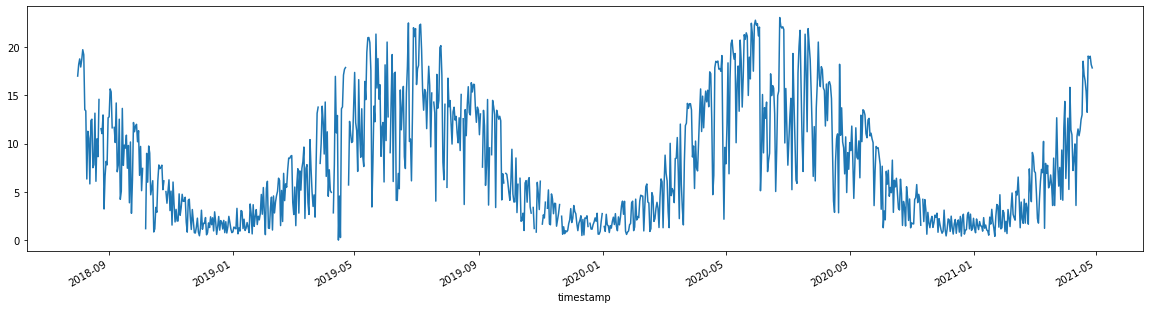

In [22]:
# Step 17 – Net solar or net shortwave radiation
α = 0.23  # hypothetical grass reference crop
Rns = (1-α)*Rs
Rns.plot()

<AxesSubplot:xlabel='timestamp'>

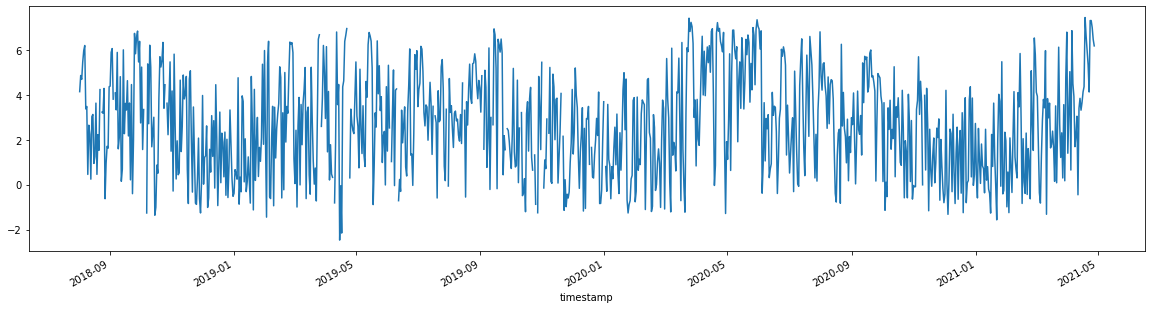

In [23]:
# Step 18 – Net outgoing long wave solar radiation
σ = 4.903e-9
Rnl = σ*(((Tmax+273.16)**4 + (Tmin+273.16)**4)/2)*(0.34-0.14*np.sqrt(ea))*(1.35*Rs/Rso - 0.35)
Rnl.plot()

<AxesSubplot:xlabel='timestamp'>

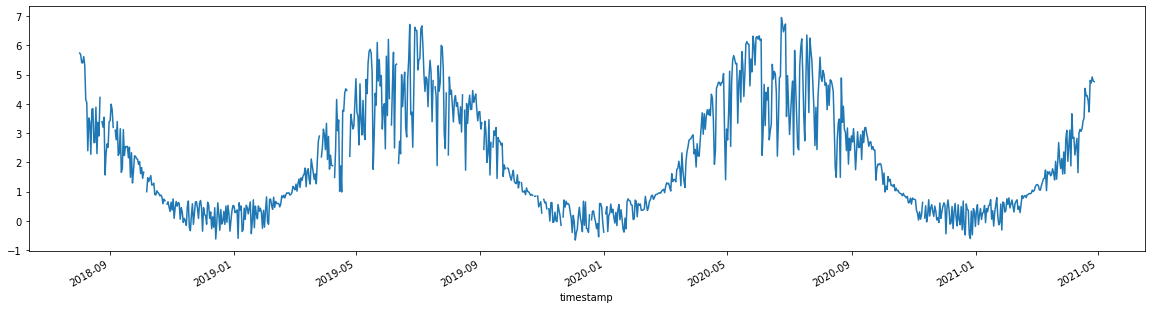

In [24]:
# Step 19 – Net radiation
Rn = Rns - Rnl
Rng = 0.408*Rn
Rng.plot()

<AxesSubplot:xlabel='timestamp'>

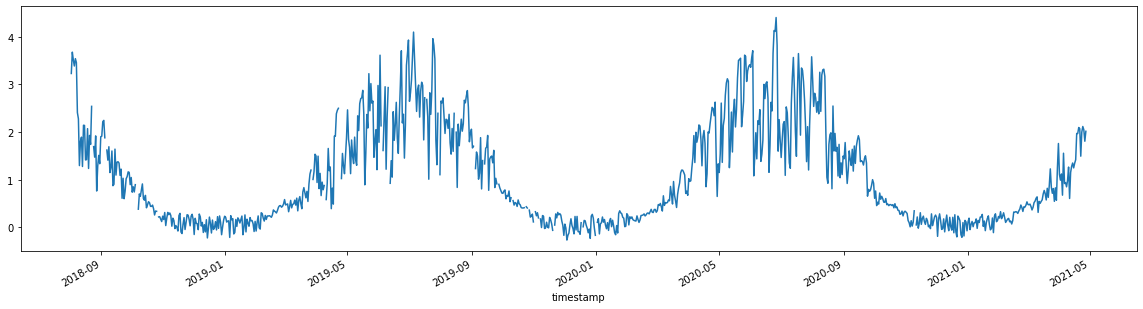

In [25]:
# Final Step – Overall ETo equation
ETrad = DT*Rng
ETrad.plot()

<AxesSubplot:xlabel='timestamp'>

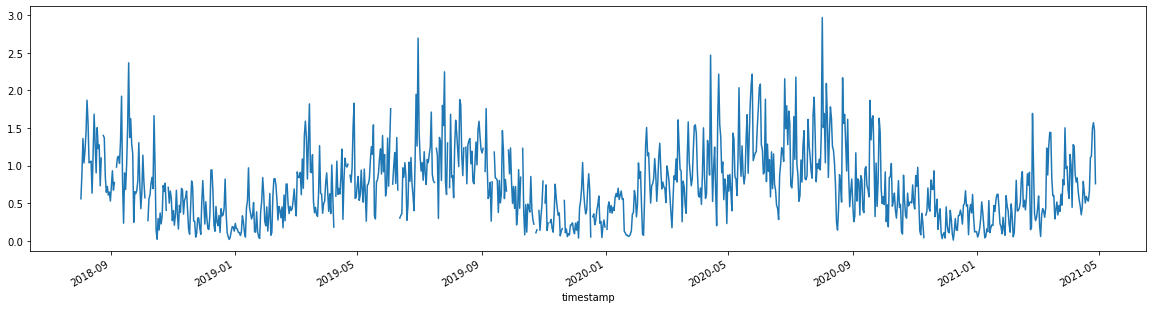

In [26]:
ETwind = PT * TT * (es-ea)
ETwind.plot()

Text(0, 0.5, 'mm/day')

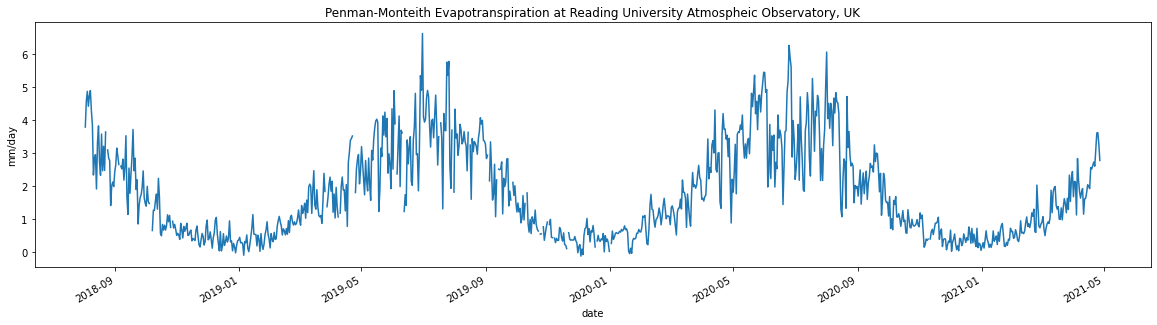

In [72]:
ET0 = ETwind + ETrad
ax =ET0.plot(
    title='Penman-Monteith Evapotranspiration at Reading University Atmospheic Observatory, UK'
)
ax.set_xlabel('date')
ax.set_ylabel('mm/day')

In [73]:
ET0_daily = ET0.copy()
ET0_daily.index = ET0_daily.index.normalize()
ET0_daily.name = 'ET0'

In [74]:
tank_evap = pd.read_csv('~/Downloads/2019_2020_tank_evap.csv', na_values='x')
tank_evap.columns = tank_evap.columns.str.strip()
tank_evap.set_index(pd.to_datetime(tank_evap[['year', 'month', 'day']]), inplace=True)

<AxesSubplot:>

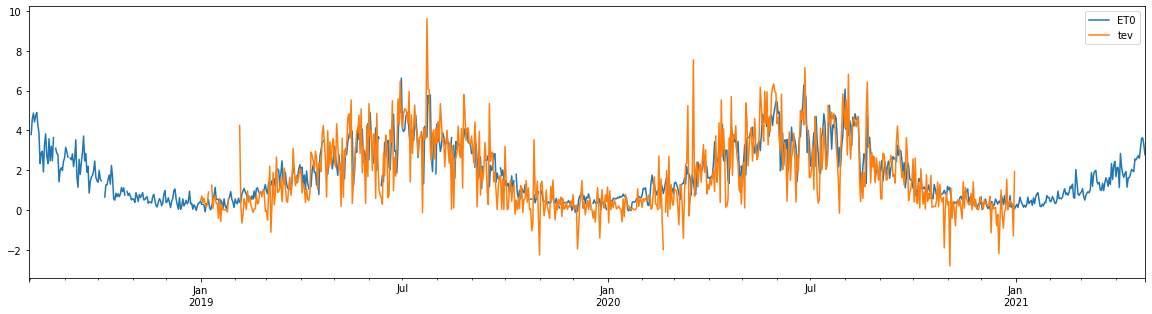

In [76]:
pd.concat([ET0_daily, tank_evap['tev']], axis='columns').plot()

<AxesSubplot:>

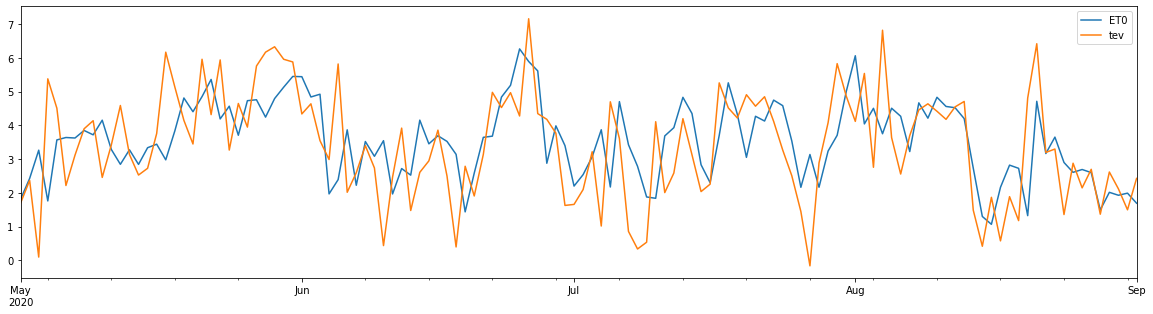

In [71]:
pd.concat([ET0, tank_evap['tev']], axis='columns').loc['2020-05-01':'2020-09-01'].plot()